In [1]:
from scipy import stats

Functions

In [2]:
def rates_from_tree(tree):
    '''Extracts rates for each species in nwk tree'''
    tree = tree.replace("(","").replace(")","")
    subs_per_sp = {sp.split(":")[0]:float(sp.split(":")[1]) for sp in tree.split(",")}
    return subs_per_sp

Read input data

In [3]:
file_rates = "../scripts/merged_features/Mammals.Homo_sapiens.features.txt.gz"
size_limit = 10e3
chrX = "chrX"

rates = pd.read_csv(file_rates,compression="gzip",sep="\t")
rates = rates[(~rates.tree.isna()) & (rates.size >= size_limit)].reset_index(drop=True)

Transform input into dataframe with number of substitutions for each mutation type in each species

In [4]:
types = [c.split("_")[-1] for c in rates.columns if "tree_" in c and "var" not in c]
subs_df = pd.DataFrame()

for i,r in rates.iterrows():
    for mut in types:
        substitutions = rates_from_tree(r["tree_{}".format(mut)])
        n = len(substitutions)
        df = pd.DataFrame([list(substitutions.keys()), 
                           list(substitutions.values()),
                           [mut]*n,
                           ["A" if r.chrom!=chrX else "X"]*n,
                           [r["size"]]*n
                          ]
                         ).transpose()
        df.columns = ["species","n_subs", "mut", "chrom", "size"]
        subs_df = pd.concat([subs_df, df])

In [9]:
subs_df["rate"] = subs_df.n_subs/subs_df.size

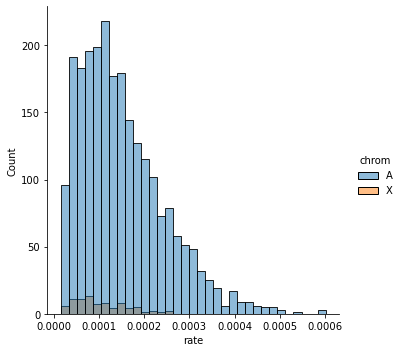

In [17]:
sp = "Microcebus_murinus"
sns.displot(data=subs_df[(subs_df.species==sp) & (subs_df.mut=="T>A")], x="rate", hue="chrom")

In [278]:
collapsed = subs_df.groupby(["species", "mut"])["n_subs"].sum().reset_index()

In [279]:
substrate_dict = collapsed[collapsed.mut.isin(["T","C"])].set_index(["species","mut"]).to_dict()["n_subs"]

In [280]:
mtypes = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
rates = []
for i,r in collapsed.iterrows():
    substrate = substrate_dict[(r.species,r.mut.split(">")[0])]
    rates.append(r.n_subs/substrate)

In [281]:
collapsed["rate"] = rates

In [282]:
#collapsed_mtype_counts = subs_df.groupby(["species", "mut"])["n_subs"].sum().reset_index()
#total_counts = collapsed_mtype_counts.groupby("species")["n_subs"].sum().to_dict()
#collapsed_mtype_counts["norm_subs"] = [r.n_subs/total_counts[r.species] for i,r in collapsed_mtype_counts.iterrows()]

In [283]:
alpha = pd.read_csv("../data/XA_2exposure-model_alphas.csv")
sp2alpha = alpha[["species","predicted_alpha"]].set_index("species").to_dict()["predicted_alpha"]
collapsed["alpha"] = [sp2alpha[sp] for sp in collapsed.species]

Comparing two mutation types (ratio)

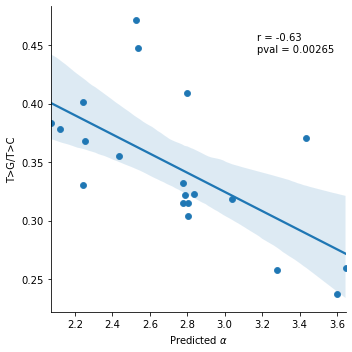

In [297]:
m1 = "T>G"
m2 = "T>C"
subd1 = collapsed[(collapsed["mut"]==m1)]# & (~collapsed_mtype_counts.species.isin(["Felis_catus","Canis_lupus_familiaris"]))]
subd2 = collapsed[(collapsed["mut"]==m2)]# & (~collapsed_mtype_counts.species.isin(["Felis_catus","Canis_lupus_familiaris"]))]
y = subd1.rate.values/subd2.rate.values
x = subd1.alpha

f,ax = plt.subplots(figsize=[5,5])
p = stats.pearsonr(x,y)
r,pval = p[0],p[1]

sns.scatterplot(x=x, y=y)
sns.regplot(x=x, y=y)
ax.text(0.7,0.85,"r = {:.2f}\npval = {:.5f}".format(r, pval),transform = ax.transAxes)
ax.set_xlabel(r"Predicted $\alpha$")
ax.set_ylabel("{}/{}".format(m1,m2))
sns.despine()
plt.tight_layout()
#f.savefig("pdfs/{}_{}_alpha.pdf".format(m1,m2))

Just one mutation type

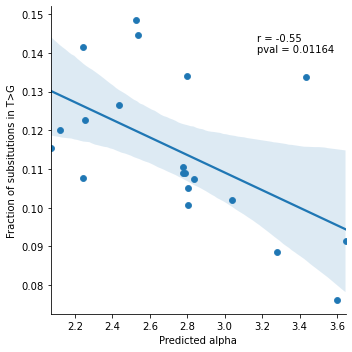

In [201]:
m = "T>G"
subd = collapsed_mtype_counts[(collapsed_mtype_counts["mut"]==m)]

x = subd.alpha
y = subd.norm_subs

f,ax = plt.subplots(figsize=[5,5])
sns.scatterplot(x=x, y=y)
sns.regplot(x=x, y=y)
p = stats.pearsonr(x,y)
r,pval = p[0],p[1]
ax.text(0.7,0.85,"r = {:.2f}\npval = {:.5f}".format(r, pval),transform = ax.transAxes)
ax.set_xlabel("Predicted alpha")
ax.set_ylabel("Fraction of subsitutions in {}".format(m))
sns.despine()
plt.tight_layout()
#f.savefig("pdfs/{}_alpha.pdf".format(m1))

All mutation types

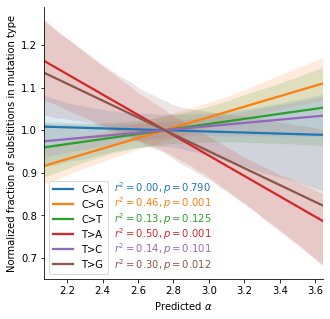

In [248]:
f,ax = plt.subplots(figsize=[5,5])
for i,(mut,df) in enumerate(collapsed_mtype_counts.groupby("mut")):
    x = df.alpha
    y = df.norm_subs
    y = y/y.mean()
    p = stats.pearsonr(x,y)
    r,pval = p[0],p[1]
    sns.regplot(x=x, y=y,ax=ax,scatter=False,label=mut)
    ax.text(0.25,0.32-(i/float(17.7)),r"$r^2 = {:.2f}, p = {:.3f}$".format(r**2, pval),transform = ax.transAxes,color="C{}".format(i))
ax.legend()
ax.set_xlabel(r"Predicted $\alpha$")
ax.set_ylabel("Normalized fraction of subsititions in mutation type")
sns.despine()
#f.savefig("pdfs/Mtypes_vs_alpha.pdf")